In [ ]:
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/genderbias

/content/gdrive/MyDrive/genderbias


In [ ]:
plt.style.use('ggplot')

Identify Image IDs of F/M containing the top 10 objects identified by logistic regression classifier.

Object Occurence Analysis

In [ ]:
F_objects = pickle.load(open('F_objects.pkl', 'rb')) # list of F image's one hot encoding of objects
M_objects = pickle.load(open('M_objects.pkl', 'rb')) # list of M image's one hot encoding of objects

humanlabels_to_onehot = pickle.load(open('humanlabels_to_onehot.pkl', 'rb'))
onehot_to_humanlabels = dict((y,x) for x,y in humanlabels_to_onehot.items())

In [ ]:
# replace M/F_objects with a list of indices where each one hot encoding is converted into indices where it equals one
F_obj_idx, M_obj_idx = [], []
for one_hot_enc in F_objects:
  F_obj_idx.append(np.where(one_hot_enc>0)[0])

for one_hot_enc in M_objects:
  M_obj_idx.append(np.where(one_hot_enc>0)[0])
  

In [ ]:
F_IMGS = len(F_obj_idx)
M_IMGS = len(M_obj_idx)
print("F_IMGS: ", F_IMGS)
print("M_IMGS: ", M_IMGS)


F_IMGS:  536
M_IMGS:  1620


In [ ]:
# create a F/M dictionary mapping object idx to object count
F_obj_count, M_obj_count = defaultdict(int), defaultdict(int) 
for obj_idx in F_obj_idx:
  for obj in obj_idx:
    F_obj_count[obj]+=1

for obj_idx in M_obj_idx:
  for obj in obj_idx:
    M_obj_count[obj]+=1

for obj_idx in list(F_obj_count.keys()):
  F_obj_count[obj_idx] = F_obj_count[obj_idx]/F_IMGS

for obj_idx in list(M_obj_count.keys()):
  M_obj_count[obj_idx] = M_obj_count[obj_idx]/M_IMGS

In [ ]:
# Find largest differnece in Male and Female objects
F_M_obj_percentdiff = {}
for obj_idx in M_obj_count:
  F_M_obj_percentdiff[obj_idx] = abs(M_obj_count[obj_idx]-F_obj_count[obj_idx])

In [ ]:
N=10
res = dict(sorted(F_M_obj_percentdiff.items(), key = itemgetter(1), reverse = True)[:N])

sorted_percentdiff = sorted(res.values())
sorted_obj_idx = [x for _,x in sorted(zip(res.values(),res.keys()))]

In [ ]:
# convert sorted_obj_name to human labels
sorted_obj_name = []
for obj_idx in sorted_obj_idx:
  sorted_obj_name.append(onehot_to_humanlabels[obj_idx])

In [ ]:
sorted_percentdiff, sorted_obj_name, sorted_obj_idx

([0.020748111295374988,
  0.022051778146305517,
  0.024824949327436896,
  0.025032246176524775,
  0.025755481850009213,
  0.028510226644554992,
  0.02874976967016768,
  0.033167495854063006,
  0.037069283213561816,
  0.03725354707941773],
 ['window-other',
  'plastic',
  'bush',
  'metal',
  'table',
  'tennis racket',
  'tree',
  'wall-other',
  'grass',
  'handbag'],
 [169, 131, 85, 120, 153, 38, 157, 161, 112, 26])

In [ ]:
F_ordered_obj,M_ordered_obj = [], []
for obj_idx in sorted_obj_idx:
  F_ordered_obj.append(F_obj_count[obj_idx])
  M_ordered_obj.append(M_obj_count[obj_idx])

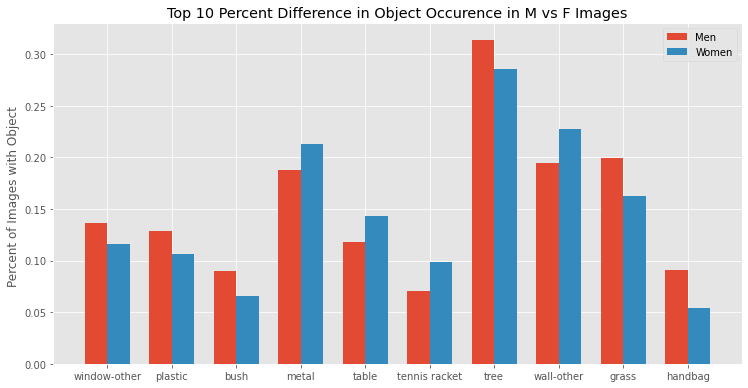

In [ ]:

labels = sorted_obj_name
men_means = M_ordered_obj
women_means = F_ordered_obj

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Images with Object ')
ax.set_title('Top 10 Percent Difference in Object Occurence in M vs F Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.set_size_inches(10.5, 5.5)

fig.tight_layout()

plt.show()

In [ ]:
res

{26: 0.03725354707941773,
 38: 0.028510226644554992,
 85: 0.024824949327436896,
 112: 0.037069283213561816,
 120: 0.025032246176524775,
 131: 0.022051778146305517,
 153: 0.025755481850009213,
 157: 0.02874976967016768,
 161: 0.033167495854063006,
 169: 0.020748111295374988}

Logistic Regression Model

In [ ]:
labels_val = pickle.load(open('labels_val.pkl', 'rb')) # image path name to one hot encoding
scores_val_list = pickle.load(open('scores_val.pkl', 'rb')) # image path name to one hot encoding
gender_labels_train = pickle.load(open('gender_labels_train.pkl', 'rb')) # image path name to one hot encoding
gender_labels_val = pickle.load(open('gender_labels_val.pkl', 'rb')) # image path name to one hot encoding

In [ ]:
# convert scores to labels
scores_val = {}
for i, score in enumerate(scores_val_list):
  img_path = list(labels_val.keys())[i]
  scores_val[img_path] = score>0.5

Ground Truth

In [ ]:
X_train, y_train, X_val, y_val = [], [], [], []
for img_path in list(gender_labels_train.keys()):
  gender = gender_labels_train[img_path]
  onehotenc = np.array(labels_val[img_path])
  X_train.append(onehotenc)
  y_train.append(gender)

for img_path in list(gender_labels_val.keys()):
  gender = gender_labels_val[img_path]
  onehotenc = np.array(labels_val[img_path])
  X_val.append(onehotenc)
  y_val.append(gender)

X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val) 

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_val, y_val)

0.7235621521335807

Standard Model's Output

In [ ]:
X_train, y_train, X_val, y_val = [], [], [], []
for img_path in list(gender_labels_train.keys()):
  gender = gender_labels_train[img_path]
  onehotenc = np.array(scores_val[img_path])
  X_train.append(onehotenc)
  y_train.append(gender)

for img_path in list(gender_labels_val.keys()):
  gender = gender_labels_val[img_path]
  onehotenc = np.array(scores_val[img_path])
  X_val.append(onehotenc)
  y_val.append(gender)

X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val) 

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_val, y_val)

0.7105751391465677

In [ ]:
print("Female: ", clf.score(X_val[y_val==1], y_val[[y_val==1]]))
print("Male: ", clf.score(X_val[y_val==0], y_val[[y_val==0]]))

Female:  0.21076233183856502
Male:  0.9354404841963685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [ ]:
N=10

top_10_idx = np.argsort(clf.coef_[0])[-N:]
bottom_10_idx = np.argsort(clf.coef_[0])[:N]

top_10_obj, bottom_10_obj = [], []

for idx in top_10_idx:
  top_10_obj.append(onehot_to_humanlabels[idx])

for idx in bottom_10_idx:
  bottom_10_obj.append(onehot_to_humanlabels[idx])

In [ ]:
top_10_obj

['rock',
 'bed',
 'floor-tile',
 'towel',
 'giraffe',
 'vase',
 'handbag',
 'apple',
 'broccoli',
 'teddy bear']

In [ ]:
len(bottom_10_obj + top_10_obj)

20

In [ ]:
np.sort(clf.coef_[0])[0:10]# + np.sort(clf.coef_[0])[-10:])

array([-2.86764856, -2.00258374, -1.51734905, -1.42600523, -1.03885806,
       -1.02873589, -1.00956641, -0.95445528, -0.93187831, -0.8429714 ])

In [ ]:
np.array(list(np.sort(clf.coef_[0])[0:10])+list(np.sort(clf.coef_[0])[-10:]))

array([-2.86764856, -2.00258374, -1.51734905, -1.42600523, -1.03885806,
       -1.02873589, -1.00956641, -0.95445528, -0.93187831, -0.8429714 ,
        0.66059617,  0.69355874,  0.71144835,  0.72994391,  0.8106366 ,
        0.82333836,  0.87594477,  0.94149913,  0.95636359,  1.02897341])

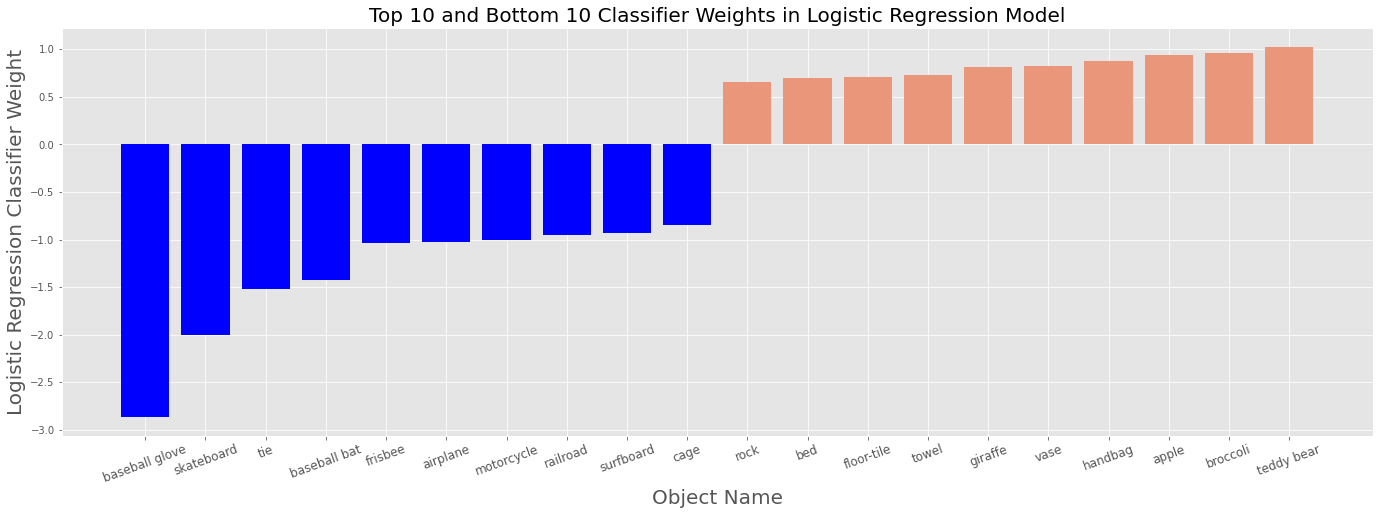

In [ ]:
'''import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(10.5, 5.5)
ax = fig.add_axes([0,0,1,1])
langs = top_10_obj
students = np.sort(clf.coef_[0])[-10:]
ax.set_ylabel('Percent of Images with Object ')
ax.set_title('Top 10 Percent Difference in Object Occurence in M vs F Images')
ax.bar(langs,students)
plt.show()'''

fig = plt.figure()
fig.set_size_inches(23.5, 7.5)

# create a dataset
height = np.array(list(np.sort(clf.coef_[0])[0:10])+list(np.sort(clf.coef_[0])[-10:]))
bars = bottom_10_obj + top_10_obj
x_pos = np.arange(len(bars))

# Create bars with different colors
colors = []
for i in range(10):
  colors.append('blue')
for i in range(10):
  colors.append('darksalmon')

plt.bar(x_pos, height, color=colors)

# Create names on the x-axis
plt.xticks(x_pos, bars, fontsize=12, rotation=20)
plt.xlabel("Object Name", fontsize=20)
plt.ylabel("Logistic Regression Classifier Weight", fontsize=20)
plt.title("Top 10 and Bottom 10 Classifier Weights in Logistic Regression Model", fontsize=20)
plt.rcParams["figure.figsize"] = (25,5)
# Show graph
plt.show()

In [ ]:
top_10_idx

array([138,  59, 105, 156,  23,  75,  26,  47,  50,  77])

NN Accuracy

In [ ]:
F_objects_imgid = pickle.load(open('F_objects_imgid.pkl', 'rb')) 
M_objects_imgid = pickle.load(open('M_objects_imgid.pkl', 'rb')) 
gender_labels_test = pickle.load(open('gender_labels_test.pkl', 'rb')) # image path name to one hot encoding

In [ ]:
F_COUNT, M_COUNT = 0, 0
for imgpath in M_objects_imgid:
  if (gender_labels_test[imgpath]==0):
    M_COUNT+=1
for imgpath in F_objects_imgid:
  if (gender_labels_test[imgpath]==1):
    F_COUNT+=1

In [ ]:
print("Female: ", F_COUNT/F_IMGS)
print("Male: ", M_COUNT/M_IMGS)

Female:  0.2798507462686567
Male:  0.7


In [ ]:
M_COUNT, M_IMGS

(1134, 1620)

In [ ]:
img_path

'/n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000581357.jpg'

In [ ]:
female_top10 = top_10_idx
male_top10 = bottom_10_idx

female_img_id = []
female_img_id_top10 = []
male_img_id = []
male_img_id_top10 = []

for img_path in list(gender_labels_test.keys()):
  objects = np.where(labels_val[img_path]==1)[0]
  img_id = int(img_path.split('/')[-1][:-4][-12:])
  top10=False
  # if female
  if gender_labels_test[img_path]:
    for o in objects:
      # find out if the objects in this image contain objects from top 10
      if o in female_top10:
        top10=True
        break
    if top10: female_img_id_top10.append(img_id)
    else: female_img_id.append(img_id)
        
  # if male
  else:
    for o in objects:
      # find out if the objects in this image contain objects from top 10
      if o in male_top10:
        top10=True
        break
    if top10: male_img_id_top10.append(img_id)
    else: male_img_id.append(img_id)

In [ ]:
print(len(female_img_id), len(female_img_id_top10), len(male_img_id), len(male_img_id_top10))

440 196 856 664


In [ ]:
from scipy.stats import ttest_ind_from_stats

# stat sig between all female and all male 

# stat sig between all top 10 vs all not top 10

ttest_ind_from_stats(mean1=0.209, std1=0.1, nobs1=440+196,
                     mean2=0.218, std2=0.1, nobs2=856+664)

Ttest_indResult(statistic=-1.9057612097262402, pvalue=0.05681419525738061)

In [ ]:
ls

classifier.py                         humanlabels_to_onehot.pkl
COCO_val2014_000000022341_female.png  labels_val.pkl
COCO_val2014_000000242365_female.png  load_data.py
F_objects_imgid.pkl                   M_objects_imgid.pkl
F_objects.pkl                         M_objects.pkl
gender_labels_test.pkl                __pycache__/
gender_labels_train.pkl               scores_val.pkl
gender_labels_val.pkl


In [ ]:
import numpy as np
import PIL
import torch
import sys
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from classifier import multilabel_classifier
from load_data import *

###                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# Referenced from:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
# https://github.com/jacobgil/pytorch-grad-cam/blob/master/gradcam.py                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
# Example usage:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
# python get_cams.py --modelpath $MODELPATH --img_ids 535811 430054 554674                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
# --modelpath: path to the model to visualize                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
# --img_ids: COCOStuff image IDs (use the Explore tool on the COCO dataset website)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
###                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

def get_heatmap(CAM_map, img):
    CAM_map = cv2.resize(CAM_map, (img.shape[0], img.shape[1]))
    CAM_map = CAM_map - np.min(CAM_map)
    CAM_map = CAM_map / np.max(CAM_map)
    CAM_map = 1.0 - CAM_map # make sure colormap is not reversed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    heatmap = cv2.applyColorMap(np.uint8(255 * CAM_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap + np.float32(img)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    return heatmap

def returnCAM(feature_conv, weight_softmax, class_labels, device):
    bz, nc, h, w = feature_conv.shape # (1, hidden_size, height, width)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
        cam = torch.mm(weight_softmax.unsqueeze(0), feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - cam.min()
        cam_img = cam / cam.max()
        output_cam = torch.cat([output_cam, cam_img.unsqueeze(0)], dim=0)
    return output_cam

def returnCAM_featuresplit(feature_conv, weight_softmax, class_labels, device, split=1024):
    feature_conv_o = feature_conv[:,:split,:,:]
    feature_conv_s = feature_conv[:,split:,:,:]
    bz, nc, h, w = feature_conv.shape
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:
        cam_o = torch.mm(weight_softmax[idx][:split].unsqueeze(0), feature_conv_o.reshape((split, h*w)))
        cam_s = torch.mm(weight_softmax[idx][split:].unsqueeze(0), feature_conv_s.reshape((nc-split, h*w)))
        cam_o = cam_o.reshape(h, w)
        cam_s = cam_s.reshape(h, w)
        cam_o = cam_o - cam_o.min()
        cam_s = cam_s - cam_s.min()
        cam_o_img = cam_o / cam_o.max()
        cam_s_img = cam_s / cam_s.max()
        output_cam = torch.cat([output_cam, cam_o_img.unsqueeze(0), cam_s_img.unsqueeze(0)], dim=0)
    return output_cam

def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--modelpath', type=str, default=None)
    # parser.add_argument('--img_ids', type=int, nargs='+', default=0)
    # parser.add_argument('--outdir', type=str, default=None)
    # parser.add_argument('--featuresplit', default=False, action="store_true")
    # parser.add_argument('--split', type=int, default=1024)
    # parser.add_argument('--coco2014_images', type=str, default='/n/fs/visualai-scr/Data/Coco/2014data')
    # parser.add_argument('--device', default=torch.device('cuda'))
    # parser.add_argument('--dtype', default=torch.float32)
    # arg = vars(parser.parse_args())
    arg = {'modelpath': 'model_199.pth', 
           'img_ids': [22341, 242365], 
           'outdir': None,
           'featuresplit': False, 
           'split': 1024,
           'coco2014_images': '',
           'device': torch.device('cuda'),
           'dtype': torch.float32}
    print(arg, '\n', flush=True)

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = T.Compose([
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor()
    ])

    classifier_features = []
    def hook_classifier_features(module, input, output):
        classifier_features.append(output)

    classifier = multilabel_classifier(device=arg['device'], dtype=arg['dtype'], modelpath=arg['modelpath'])
    classifier.model = classifier.model.to(device=classifier.device, dtype=classifier.dtype)

    classifier.model._modules['resnet'].layer4.register_forward_hook(hook_classifier_features)
    classifier_params = list(classifier.model.parameters())
    classifier_softmax_weight = classifier_params[-2].squeeze(0)

    for img_id in arg['img_ids']:
        # Open image                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
        img_path = '{}/train2014/COCO_train2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
        img_name = img_path.split('/')[-1][:-4]
        if not os.path.exists(img_path):
            # Try searching in val set                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            img_path = '{}/val2014/COCO_val2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
            print('img_path: ', img_path)
            img_name = img_path.split('/')[-1][:-4]
            if not os.path.exists(img_path):
                print('WARNING: Could not find img {}'.format(img_id), flush=True)
                continue
        original_img = Image.open(img_path).convert('RGB')

        if arg['outdir'] != None:
            outdir = '{}/{}'.format(arg['outdir'], img_id)
        else:
            outdir = str(img_id)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        print('Processing img {}'.format(img_id), flush=True)

        # Get image class labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
        img_labels = pickle.load(open('data/gender_labels_train.pkl', 'rb'))
        if img_path in img_labels:
            if torch.cuda.device_count() > 0:
                class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')
            else:
                class_labels = img_labels[img_path].type('torch.ByteTensor')
        else:
            img_labels = pickle.load(open('data/gender_labels_test.pkl', 'rb'))
            if img_path in img_labels:
                if torch.cuda.device_count() > 0:
                    class_labels = [img_labels[img_path]]
                    #class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
                else:
                    class_labels = [img_labels[img_path]]
                    class_labels = img_labels[img_path].type('torch.ByteTensor')
            else:
                print('No labels found for image {}'.format(img_path), flush=True)
                class_labels = torch.zeros(1)
        #class_labels = torch.flatten(torch.nonzero(class_labels))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
        class_labels = torch.FloatTensor(class_labels)
        classifier_features.clear()
        img = transform(original_img)
        norm_img = normalize(img)
        norm_img = norm_img.to(device=classifier.device, dtype=classifier.dtype)
        norm_img = norm_img.unsqueeze(0)
        x = classifier.forward(norm_img)

        if arg['featuresplit']:
            CAMs = returnCAM_featuresplit(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'], split=arg['split'])
        else:
            CAMs = returnCAM(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'])
        CAMs = CAMs.detach().cpu().numpy()

        # Save CAM heatmap                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        #humanlabels_to_onehot = pickle.load(open('/n/fs/context-scr/data/COCOStuff/humanlabels_to_onehot.pkl', 'rb'))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
        #onehot_to_humanlabels = {v: k for k,v in humanlabels_to_onehot.items()}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
        onehot_to_humanlabels= {0: 'male',
                                1: 'female'}
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
        class_labels = class_labels.cpu().detach().numpy()
        if arg['featuresplit']:
            for i in range(len(class_labels)):
                heatmap_o = get_heatmap(CAMs[2*i], img)
                heatmap_s = get_heatmap(CAMs[2*i+1], img)

                fig = plt.figure()
                fig_o = fig.add_subplot(121)
                fig_o.imshow(heatmap_o)
                fig_o.axis('off')
                fig_o.set_title('{} ({})'.format(onehot_to_humanlabels[class_labels[i]], 'Wo'))

                fig_s = fig.add_subplot(122)
                fig_s.imshow(heatmap_s)
                fig_s.axis('off')
                fig_s.set_title('{} ({})'.format(onehot_to_humanlabels[class_labels[i]], 'Ws'))
                humanlabel = onehot_to_humanlabels[class_labels[i]].replace(' ', '+')
                plt.savefig('{}/{}_{}.png'.format(outdir, img_name, humanlabel))
                plt.show()
                plt.close()
        else:
            for i in range(len(class_labels)):
                heatmap = get_heatmap(CAMs[i], img)
                plt.figure()
                plt.imshow(heatmap)
                plt.axis('off')
                plt.title(onehot_to_humanlabels[class_labels[i]])
                humanlabel = onehot_to_humanlabels[class_labels[i]].replace(' ', '+')
                plt.savefig('{}/{}_{}.png'.format(outdir, img_name, humanlabel))
                plt.show()
                plt.close()

if __name__ == '__main__':
    main()


